In [131]:
import pandas as pd
import numpy as np
import datetime
from filegenerators import *
pd.options.display.float_format = '{:.2e}'.format
from pathlib import Path
from CovCor_calc import OptimaMechtest, OptimaOutput, OptimaSensitivity
import seaborn as sns
import matplotlib.pyplot as plt
import os
import copy
from scipy.linalg import sqrtm, logm
pd.set_option('display.float_format', '{:.6e}'.format)

In [2]:
"""
If ic=0 => absolute sigma => dataPoint variablestd = small error
If ic!=0 rel sigma => common properties => new property value = ln((val/1.5)/(val*1.5))/4
"""
def splitSigmas(df, inputs, observables, must_be_zero, wide=False):
    rel_sigmas = dict()
    abs_sigmas = dict()

    for index, row in df.iterrows():
        if row.species in inputs:
#        if row.species not in observables:
            continue
        if row.value in must_be_zero and row.species not in inputs:
            rel_sigmas[row.species] = 5e-14
        elif row.species not in inputs and row.species in observables:
            if wide:
                rel_sigmas[row.species] = ((row.maxconc-row.minconc)/8)*1e-12
            else:
                rel_sigmas[row.species] = ((row.value*1.5-row.value/2)/8)*1e-12
    return rel_sigmas

In [3]:
df_species_ics = pd.read_excel('input_files/reactions_ics_finalised.xlsx', sheet_name='icranges')
df_species_ics['value'] = df_species_ics['value'].astype(float)

observables = []
for index, row in df_species_ics.iterrows():
    if row.value > 0:
        observables.append(row.species)
with open ('observables.txt', 'w') as f:
    for spec in observables:
        f.write(f"{spec}\n")
len(observables)

35

In [4]:
#inoputokat ki kell szedni
input_names =  ['nS', 'RAP', 'TG', 'dS', 'CCH', 'REF', 'Insulin', 'TG_SERCA', 'mTOR_RAP', 'casp', 'IP3R', 'Baxa', 'tBid']
must_be_zero = ['casp', 'Baxa', 'tBid', 'p53a', 'PUMA']
inputs = {}
for i in input_names:
    inputs[i] = 0.0
inputs["REF"] = 1.0
inputs["Insulin"] = 1e-10

In [5]:
input_data = pd.DataFrame([
    {'species': species, 'minconc': value, 'value': value, 'maxconc': value}
    for species, value in inputs.items()
])

In [6]:
lut = pd.concat([df_species_ics, input_data], ignore_index=True)    # look-up-table
lut['species'] = lut['species'].str.upper()
lut.shape

(84, 4)

In [7]:
naro_sigmas = splitSigmas(df=df_species_ics, inputs=inputs, observables=observables, must_be_zero=must_be_zero)
wide_sigmas = splitSigmas(df=df_species_ics, inputs=inputs, observables=observables, must_be_zero=must_be_zero, wide=True)
len(naro_sigmas)

34

In [9]:
old_ones: dict[str, OptimaMechtest] = {}
new_ones: dict[str, OptimaMechtest] = {}
old_indices = ['1000', '2000', '3000', '4000', '5000']
new_indices = ['1000', '2000', '3000', '4000', '5000',
               '6000', '7000', '8000', '9000', '10000',
               '11000', '12000', '13000', '14000', '15000']
for idx in old_indices:
    old_ones[idx] = OptimaMechtest(f"2025526_BCRN_corr_{idx}_old.opp")

for idx in new_indices:
    new_ones[idx] = OptimaMechtest(f"2025526_BCRN_corr_{idx}_new.opp")

In [11]:
# calculates the distance between the measurements and normalise them with the appropriate sigma value
def sigma_range(meas, sim, sigma):
    radius = (sim-meas)/sigma
    return radius

In [13]:
def isit_init(row, wide=False):
    for k, v in row.items():
        right_row = lut[lut['species'] == k]

        if right_row.empty or k not in naro_sigmas.keys():
            #print(f"Species '{species}' not found in lut — skipping.")
            continue    # ezekre: BEC1A, PI3K, PI3KA, SERCAA nincsen adat a ranges tablazatban

        meas = right_row['value'].iloc[0] * 1e-12

        if not wide:
            radius = sigma_range(meas=meas, sim=v*1e-12, sigma=naro_sigmas[k])
        else:
            radius = sigma_range(meas=meas, sim=v*1e-12, sigma=wide_sigmas[k])
        #print(radius)
        if radius >= 4:
            return False

    return True


In [26]:
all_ok = True
old_good_xmls = []
new_good_xmls = []

for idx in old_indices:
    for xml_name, row in old_ones[idx].df_followed34.iterrows():
        all_ok = isit_init(row)
        if all_ok:
            old_good_xmls.append(xml_name)

for idx in new_indices:
    for xml_name, row in new_ones[idx].df_followed34.iterrows():
        all_ok = isit_init(row, True)
        if all_ok:
            new_good_xmls.append(xml_name)

len(old_good_xmls), len(new_good_xmls)

(4733, 1814)

In [175]:
data_old = copy.deepcopy(old_ones)      # fckn python does all assignments with shitty references, duuuuhh
data_new = copy.deepcopy(new_ones)

In [176]:
# Filtering
first = True
filtered_basal_old = pd.DataFrame()
filtered_followed_old = pd.DataFrame()
for k, v in data_old.items():
    v.df_basal.index = v.df_basal.index.str[7:-9]
    v.df_basal = v.df_basal.sort_index()
    if first:
        filtered_basal_old = v.df_basal[[xml in old_good_xmls for xml in v.df_basal.index]]
        filtered_followed_old = v.df_followed34[[xml in old_good_xmls for xml in v.df_followed34.index]]
        first = False
    else:
        filtered_basal_old = pd.concat([filtered_basal_old, v.df_basal[[xml in old_good_xmls for xml in v.df_basal.index]]],
                                   ignore_index=False)
        filtered_followed_old = pd.concat([filtered_followed_old, v.df_followed34[[xml in old_good_xmls for xml in v.df_followed34.index]]],
                                      ignore_index=False)

In [177]:
first = True
filtered_basal_new = pd.DataFrame()
filtered_followed_new = pd.DataFrame()
for kk, vv in data_new.items():
    vv.df_basal.index = vv.df_basal.index.str[7:-9] # states_stac_10567_p1_BCRN6
    vv.df_basal = vv.df_basal.sort_index()
    if first:
        filtered_basal_new = vv.df_basal[[xml in new_good_xmls for xml in vv.df_basal.index]]
        filtered_followed_new = vv.df_followed34[[xml in new_good_xmls for xml in vv.df_followed34.index]]
        first = False
    else:
        filtered_basal_new = pd.concat([filtered_basal_new, vv.df_basal[[xml in new_good_xmls for xml in vv.df_basal.index]]],
                                   ignore_index=False)
        filtered_followed_new = pd.concat([filtered_followed_new, vv.df_followed34[[xml in new_good_xmls for xml in vv.df_followed34.index]]],
                                      ignore_index=False)

In [178]:
filtered_followed_new.shape

(1814, 34)

In [189]:
corr_xmls = [50]
dict_old_f = {}   # Ebbe lesznek az adott sorszamu dataframe-ek
dict_old_b = {}
dict_new_f = {}   # for df_followed34
dict_new_b = {}   # for df_basal
dict_old_f_corr = {}
dict_old_b_corr = {}
dict_new_f_corr = {}
dict_new_b_corr = {}
dict_old_f_cov = {}
dict_old_b_cov = {}
dict_new_f_cov = {}
dict_new_b_cov = {}

In [192]:
corr_xmls_old = [np.arange(0, 50, 1), np.arange(50, 200, 1), np.arange(200, 500, 1),
             np.arange(500, 1000, 1), np.arange(1000, 2000, 1), np.arange(2000, len(old_good_xmls), 1)]
keys_old = ['50', '150', '300', '500', '1000', f"{len(old_good_xmls) - 2000}"]

corr_xmls_new = [np.arange(0, 50, 1), np.arange(50, 300, 1), np.arange(300, 800, 1),
             np.arange(800, len(new_good_xmls), 1)]
keys_new = ['50', '250', '500', f"{len(new_good_xmls) - 800}"]

to_remove = ['x_SERCAA', 'x_TG', 'x_TG_SERCA', 'x_MTOR_RAP']

bold_nona = copy.deepcopy(filtered_basal_old)
bnew_nona = copy.deepcopy(filtered_basal_new)

for kill_it in to_remove:
    bold_nona.drop(kill_it, axis=1, inplace=True)
    bnew_nona.drop(kill_it, axis=1, inplace=True)

In [194]:

for idx, range in enumerate(corr_xmls_old):
    dict_old_f[f"{keys_old[idx]}"] = filtered_followed_old.iloc[range].copy()
    dict_old_b[f"{keys_old[idx]}"] = filtered_basal_old.iloc[range].copy()
    dict_old_f_corr[f"{keys_old[idx]}"] = filtered_followed_old.iloc[range].copy().corr()
    dict_old_b_corr[f"{keys_old[idx]}"] = filtered_basal_old.iloc[range].copy().corr()
    dict_old_f_cov[f"{keys_old[idx]}"] = filtered_followed_old.iloc[range].copy().cov()
    dict_old_b_cov[f"{keys_old[idx]}"] = bold_nona.iloc[range].copy().cov()

for idx, range_n in enumerate(corr_xmls_new):
    dict_new_f[f"{keys_new[idx]}"] = filtered_followed_new.iloc[range_n].copy()
    dict_new_b[f"{keys_new[idx]}"] = filtered_basal_new.iloc[range_n].copy()
    dict_new_f_corr[f"{keys_new[idx]}"] = filtered_followed_new.iloc[range_n].copy().corr()
    dict_new_b_corr[f"{keys_new[idx]}"] = filtered_basal_new.iloc[range_n].copy().corr()
    dict_new_f_cov[f"{keys_new[idx]}"] = filtered_followed_new.iloc[range_n].copy().cov()
    dict_new_b_cov[f"{keys_new[idx]}"] = bnew_nona.iloc[range_n].copy().cov()

In [ ]:
def plot_corr_matrix(df_corr, title="", figsize=(12, 10), vmin=-1, vmax=1, fontsize=7, dropNa = False, save_fig=False):
    
    if dropNa:
        df_corr = df_corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

    plt.figure(figsize=figsize)
    sns.heatmap(df_corr, 
                annot=False, 
                cmap='coolwarm', 
                center=0,
                vmin=vmin,
                vmax=vmax,
                xticklabels=True,
                yticklabels=True,
                square=True,
                linewidths=0.3,
                cbar_kws={"shrink": 0.8})
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f"pics/{title}.pdf")
    plt.show()

In [225]:
def plot_cov_matrix(df_cov, title="", figsize=(12, 10), fontsize=7, dropNa = False, save_fig=False):

    if dropNa:
        df_cov = df_cov.dropna(axis=0, how='all').dropna(axis=1, how='all')

    plt.figure(figsize=figsize)
    sns.heatmap(df_cov, 
                annot=False, 
                cmap='coolwarm', 
                center=0,
                xticklabels=True,
                yticklabels=True,
                square=True,
                linewidths=0.3,
                cbar_kws={"shrink": 0.8})
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f"pics/{title}.pdf")
    plt.show()

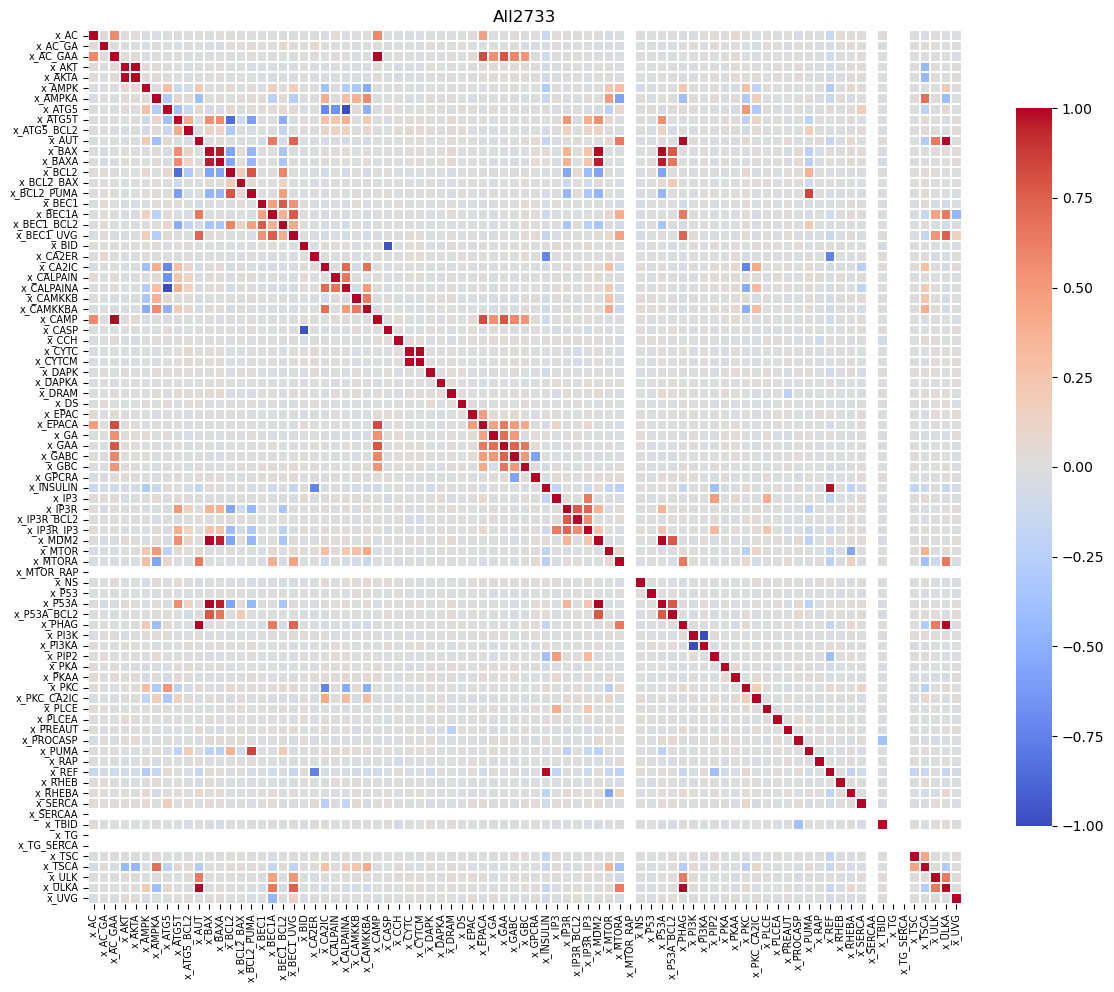

In [168]:
plot_corr_matrix(dict_old_b_corr['2733'], title='All2733')#, dropNa=True)

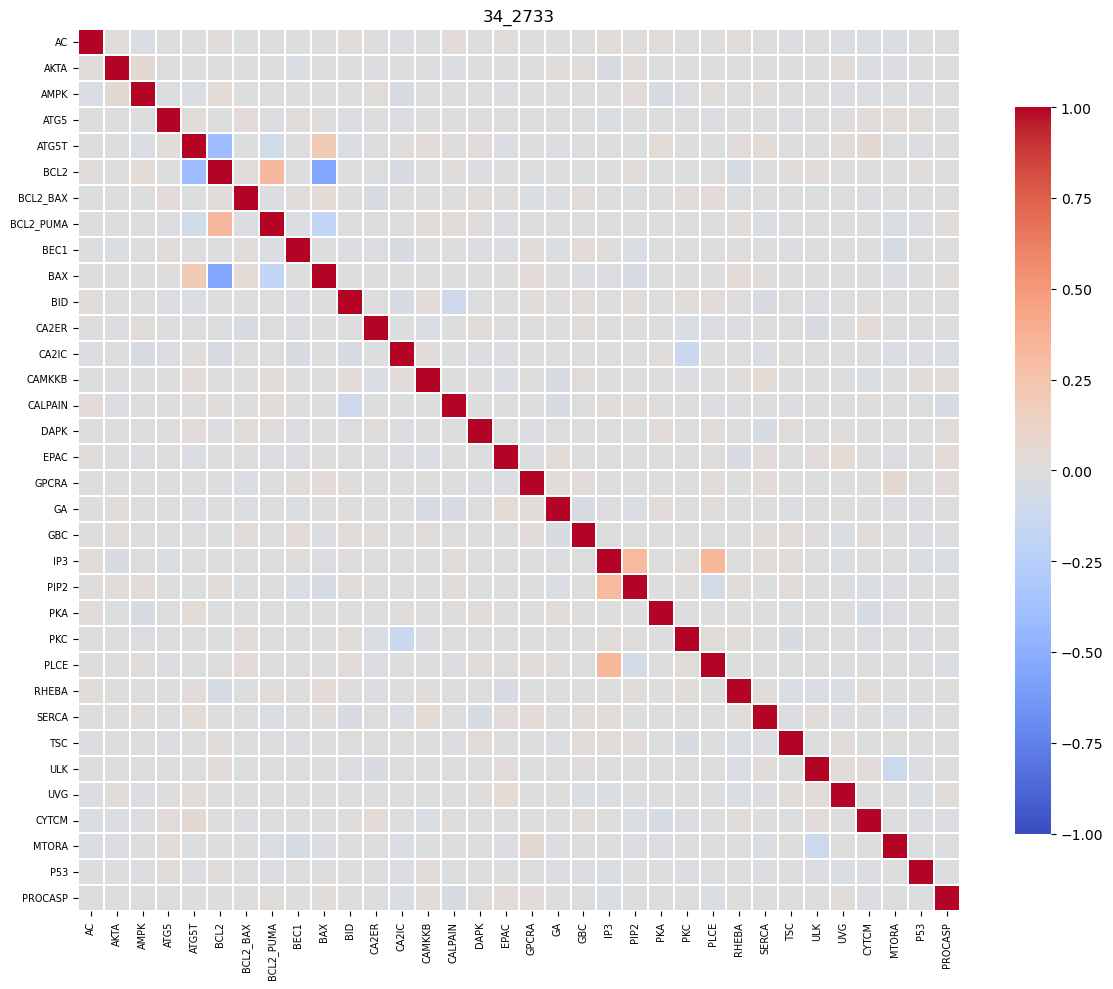

In [122]:
plot_corr_matrix(dict_old_f_corr['2733'], title='34_2733')

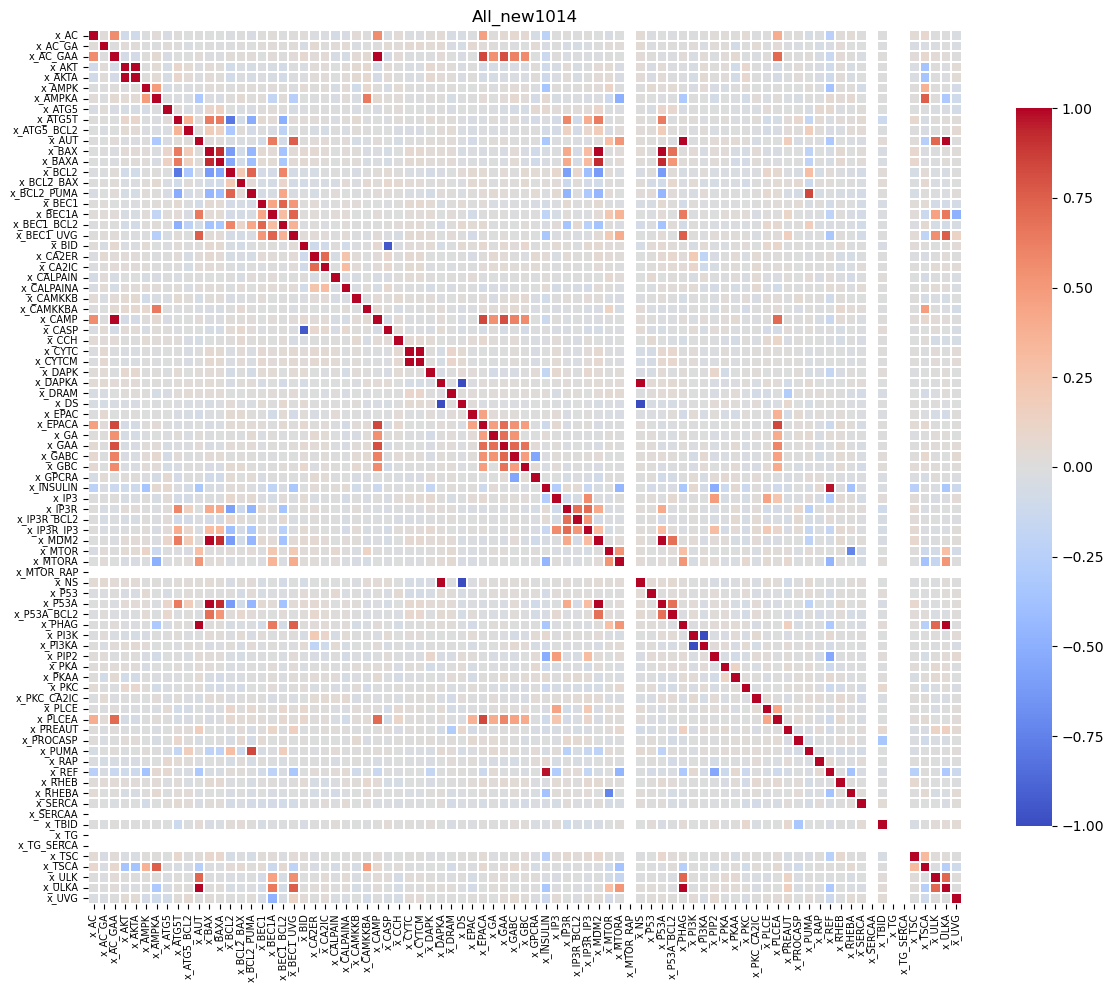

In [105]:
plot_corr_matrix(dict_new_b_corr['1014'], 'All_new1014')

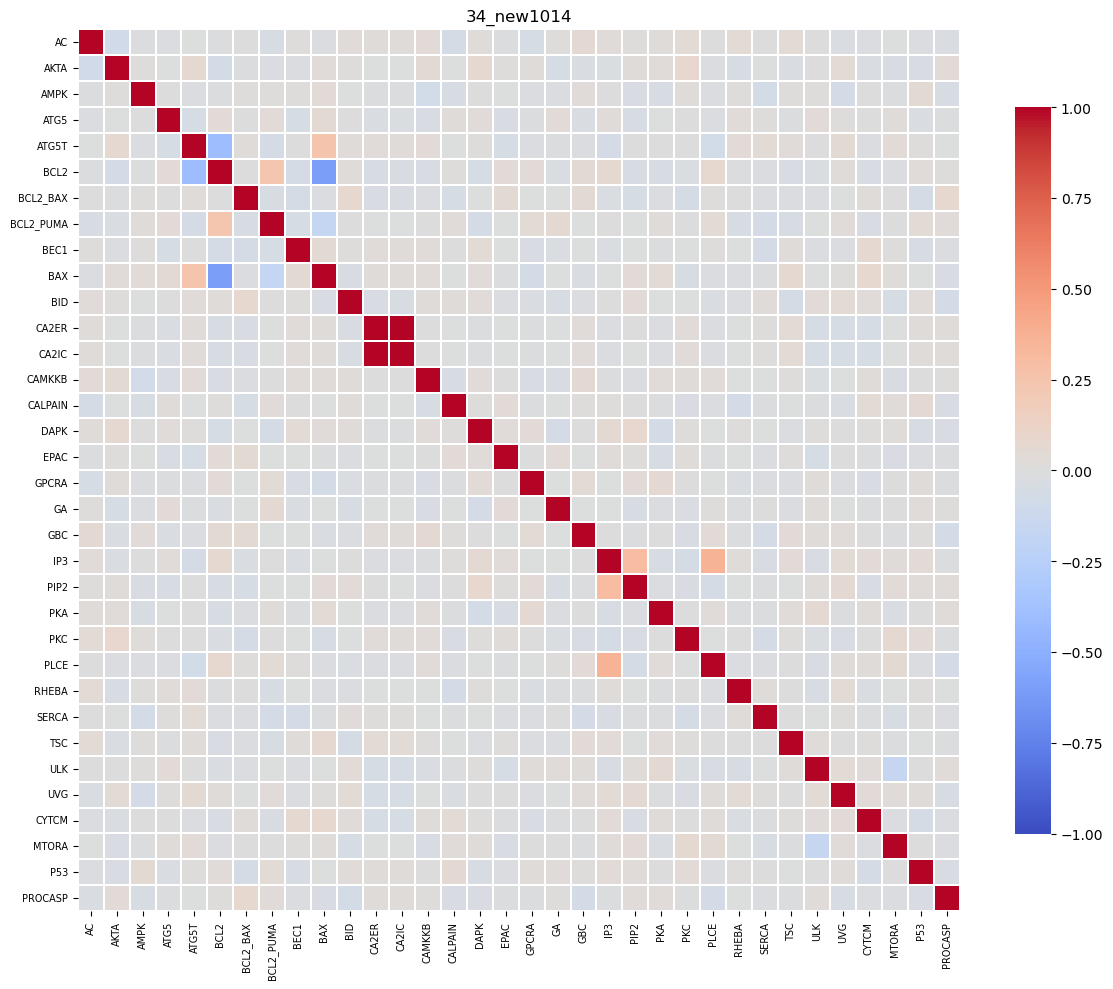

In [106]:
plot_corr_matrix(dict_new_f_corr['1014'], '34_new1014')

In [198]:
try:
    np.linalg.cholesky(dict_old_b_cov['2733'])
    print("Matrix is positive definite")
except:
    print('Ajjaj')

Matrix is positive definite


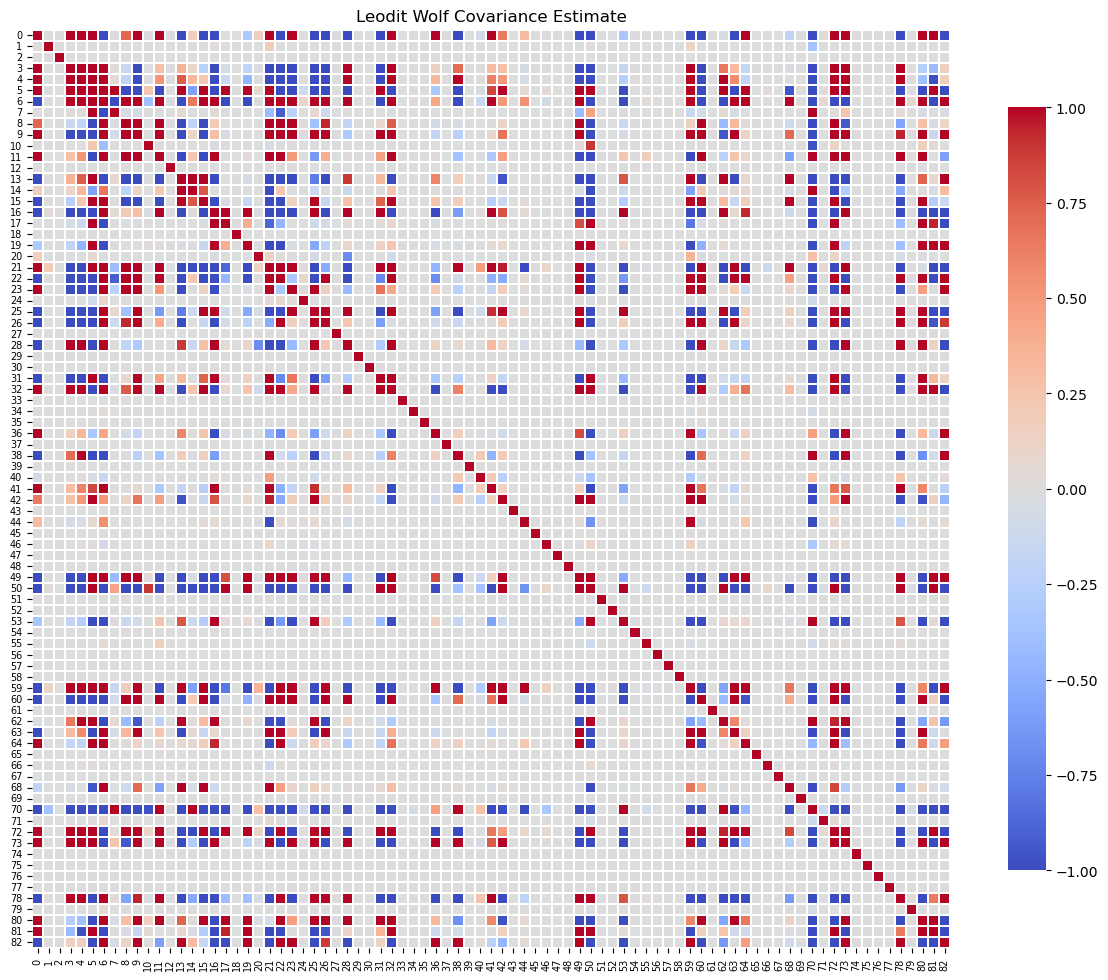

0.0004854024893281436

In [228]:
from sklearn.covariance import empirical_covariance, ledoit_wolf
covariance, shrinkage = ledoit_wolf(filtered_basal_old)
plot_corr_matrix(covariance, 'Leodit Wolf Covariance Estimate')
shrinkage

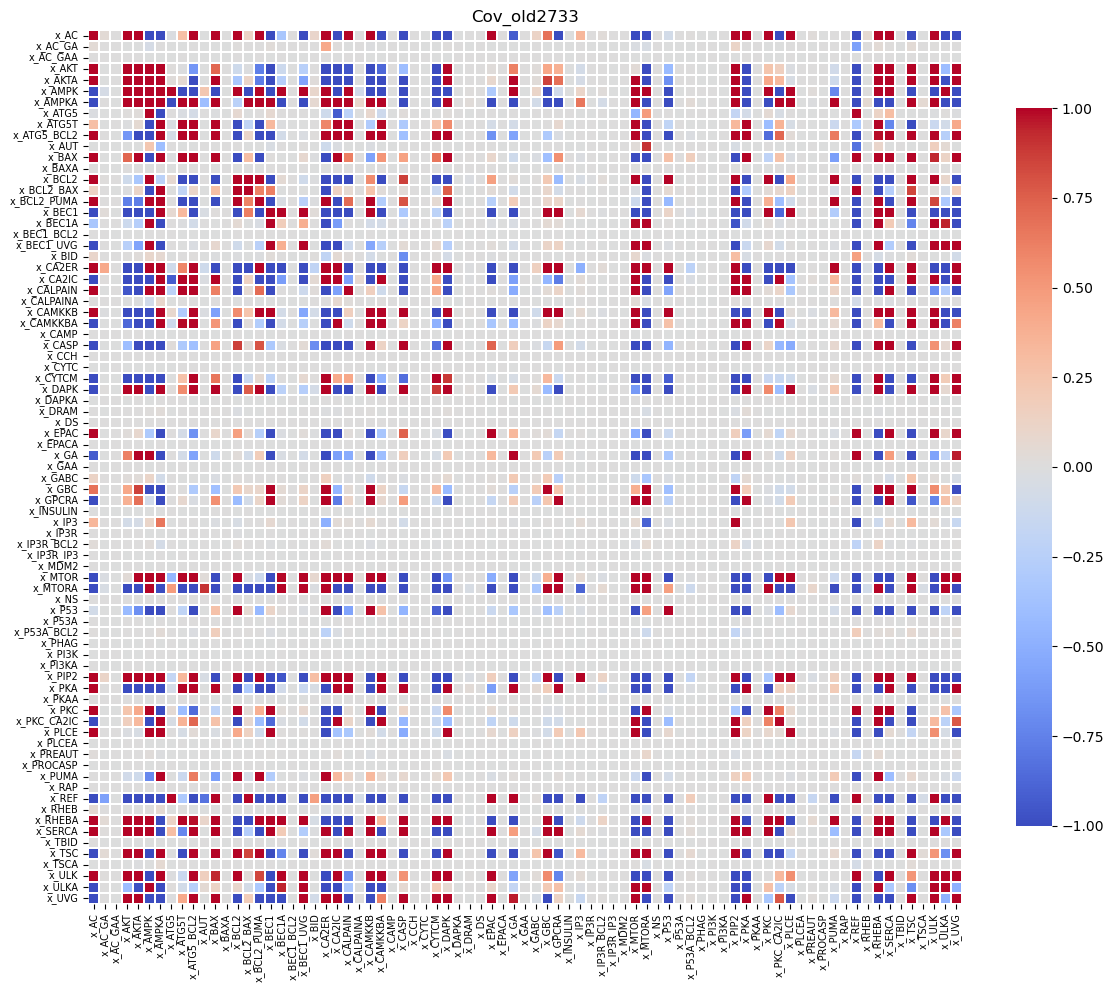

In [ ]:
vmin = min(dict_old_b_cov['2733'][min(dict_old_b_cov['2733'])])
vmax = max(dict_old_b_cov['2733'][max(dict_old_b_cov['2733'])])
plot_corr_matrix(dict_old_b_cov['2733'], "Cov_old2733")

In [222]:
to_kill = ['x_AC_GAA', 'x_BAXA', 'x_BEC1_BCL2', 'x_CAMP', 'x_CCH', 'x_CYTC', 'x_DAPKA', 'x_DRAM', 'x_DS', 'x_EPACA',
           'x_GAA', 'x_INSULIN', 'x_IP3R', 'x_IP3R_IP3', 'x_NS', 'x_P53A', 'x_PHAG', 'x_PI3K', 'x_PI3KA', 'x_PKAA',
           'x_PLCEA', 'x_PROCASP', 'x_RAP', 'x_TBID']

pls = {}

for k, v in dict_old_b_cov.items():
    for kill in to_kill:
        pls[k] = v.drop(kill, axis=1)
pls

{'50':                   x_AC       x_AC_GA      x_AC_GAA         x_AKT  \
 x_AC      2.690715e+03 -3.845858e-01  3.601061e-04 -4.753975e+01   
 x_AC_GA  -3.845858e-01  7.115029e-04  1.915653e-08  1.368216e-02   
 x_AC_GAA  3.601061e-04  1.915653e-08  3.466225e-10 -1.297613e-05   
 x_AKT    -4.753975e+01  1.368216e-02 -1.297613e-05  1.164359e+02   
 x_AKTA   -8.943546e+01  2.554178e-02 -1.788882e-05  2.092654e+02   
 ...                ...           ...           ...           ...   
 x_TSC    -8.946569e+02 -2.881336e-02  1.270251e-05 -5.256236e+01   
 x_TSCA   -3.491306e-03 -7.652202e-06 -2.048603e-09 -5.431211e-03   
 x_ULK     1.043004e+02 -1.045076e-01 -1.149957e-05  1.286266e+01   
 x_ULKA    8.935456e+00  5.730773e-03 -2.063055e-06  6.926719e+00   
 x_UVG     1.788318e+02 -6.489135e-03 -1.150264e-05 -1.442326e+01   
 
                 x_AKTA        x_AMPK       x_AMPKA        x_ATG5  \
 x_AC     -8.943546e+01  2.332044e+02 -1.509455e+02  5.987503e-01   
 x_AC_GA   2.554178e-02  9

In [216]:
def correlation_matrix_distance(A, B):
    """Correlation Matrix Distance (CMD), Herdin et al. (2005), https://doi.org/10.1049/el:20057319"""
    numerator = np.trace(A @ B)
    denominator = np.linalg.norm(A, 'fro') * np.linalg.norm(B, 'fro')
    return 1 - (numerator / denominator)

def rv_coefficient(A, B):
    """RV Coefficient, Escoufier (1973), https://doi.org/10.1016/0378-3758(78)90121-8"""
    numerator = np.trace(A @ B)
    denominator = np.sqrt(np.trace(A @ A) * np.trace(B @ B))
    return numerator / denominator

def safe_airm(A, B, epsilon=1e+1):
    """If COV() matrix is singular, https://doi.org/10.1016/S0047-259X(03)00096-4"""
    A_spd = A + epsilon * np.eye(A.shape[0])
    B_spd = B + epsilon * np.eye(B.shape[0])
    A_inv_sqrt = np.linalg.inv(sqrtm(A_spd))
    log_term = logm(A_inv_sqrt @ B_spd @ A_inv_sqrt)
    return np.linalg.norm(log_term, 'fro')

def affine_invariant_riemannian(A, B):
    """Affine-Invariant Riemannian Distance, https://doi.org/10.1007/s11263-005-3222-z"""
    try:
        A_inv_sqrt = np.linalg.inv(sqrtm(A))
        log_term = logm(A_inv_sqrt @ B @ A_inv_sqrt)
        return np.linalg.norm(log_term, 'fro')
    except:
        print("Matrix is singular, switching to linear shrinkage estimator formula")
        safe_airm(A, B)

def bures_wasserstein_distance(A, B):
    """Bures–Wasserstein Distance, https://doi.org/10.1016/0047-259X(82)90077-X"""
    sqrtA = sqrtm(A)
    middle = sqrtm(sqrtA @ B @ sqrtA)
    return np.sqrt(np.trace(A + B - 2 * middle))

def root_stein_divergence(A, B):
    """Root Stein Divergence, Sra, A New Metric on the Manifold of Kernel Matrices with Application to Matrix Geometric Means, NIPS, 2012"""
    sqrt_product = sqrtm(A @ B)
    return np.trace(A + B - 2 * sqrt_product)

In [134]:
def compute_matrix_distance(mat1, mat2, method='fro'):
    if method == 'frobenius':
        return np.linalg.norm(mat1 - mat2, ord='fro')
    elif method == 'cmd':
        return correlation_matrix_distance(mat1, mat2)
    elif method == 'rv':
        return rv_coefficient(mat1, mat2)
    elif method == 'airm':
        return affine_invariant_riemannian(mat1, mat2)
    elif method == 'bures':
        return bures_wasserstein_distance(mat1, mat2)
    elif method == 'rsd':
        return root_stein_divergence(mat1, mat2)
    else:
        raise ValueError("Unknown method. Use 'frobenius', 'cmd', 'rv', 'airm', 'skl', 'bures', or 'rsd'.")

In [203]:
def plot_correlation_distance_heatmap(corr_dict, corr_xmls, method='frobenius', save_fig=False):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = corr_dict[str(n1)].values
            mat2 = corr_dict[str(n2)].values
            distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)

    plt.figure(figsize=(8, 6))
    sns.heatmap(distance_matrix,
                xticklabels=corr_xmls,
                yticklabels=corr_xmls,
                annot=True,
                cmap='coolwarm',
                square=True,
                cbar_kws={'label': f'{method.capitalize()} Distance'})
    plt.title(f'{method.capitalize()} Distance Between Correlation Matrices')
    plt.xlabel('Number of XMLs')
    plt.ylabel('Number of XMLs')
    plt.tight_layout()
    if save_fig:
        plt.savefig(f"pics/{method.upper()}_dist.pdf")
    plt.show()

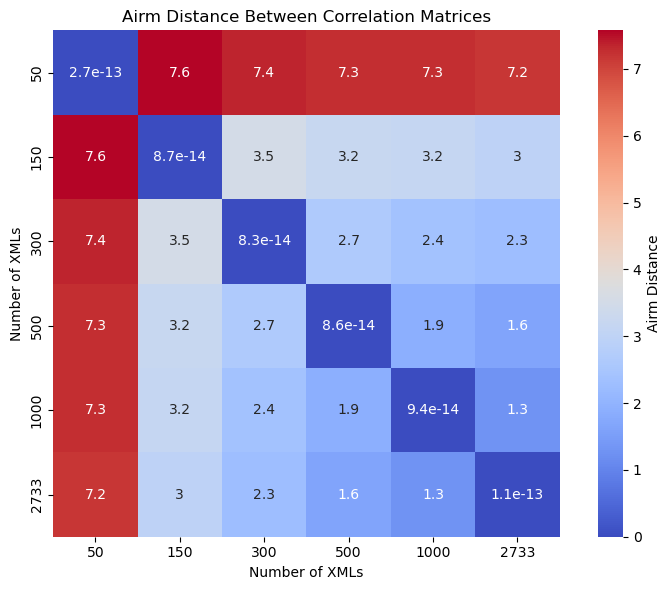

In [145]:
plot_correlation_distance_heatmap(corr_dict=dict_old_f_cov, corr_xmls=keys_old, method='airm', save_fig=True)

logm result may be inaccurate, approximate err = 6.964716120709479e-09
logm result may be inaccurate, approximate err = 1.1071904217520938e-08
logm result may be inaccurate, approximate err = 2.879644660739413e-07
logm result may be inaccurate, approximate err = 3.8256607165663124e-10
logm result may be inaccurate, approximate err = 1.5817445096274854e-06
logm result may be inaccurate, approximate err = 1.7381431700991957e-08
logm result may be inaccurate, approximate err = 1.707274554406867e-10
logm result may be inaccurate, approximate err = 1.2467183542476261e-08
logm result may be inaccurate, approximate err = 1.026479461546382e-07


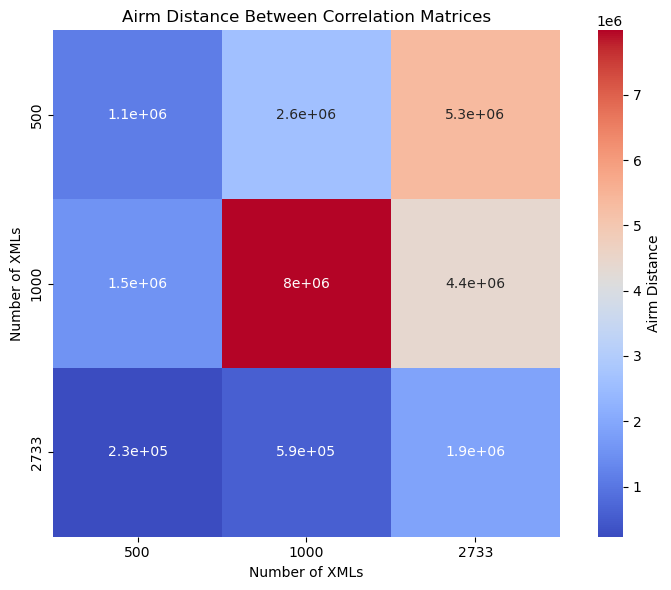

In [220]:
dic = {k: v for k, v in dict_old_b_cov.items() if float(k) > 400}
plot_correlation_distance_heatmap(corr_dict=dic, corr_xmls=keys_old[-3:], method='airm', save_fig=True)

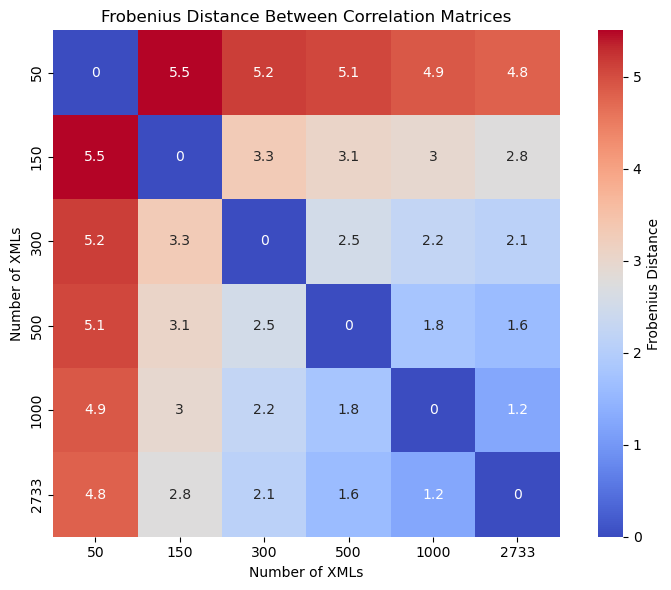

In [110]:
plot_correlation_distance_heatmap(corr_dict=dict_old_f_corr, corr_xmls=keys_old)

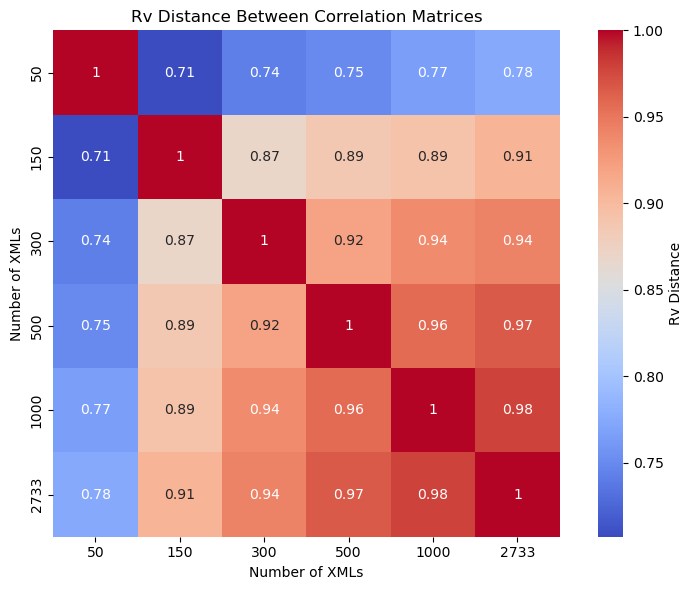

'\nRV metric:\n    - Bounded between 0 and 1\n    - 1 indicates identical structure (up to scale)\n'

In [111]:
plot_correlation_distance_heatmap(corr_dict=dict_old_f_corr, corr_xmls=keys_old, method='rv')
"""
RV metric:
    - Bounded between 0 and 1
    - 1 indicates identical structure (up to scale)
"""

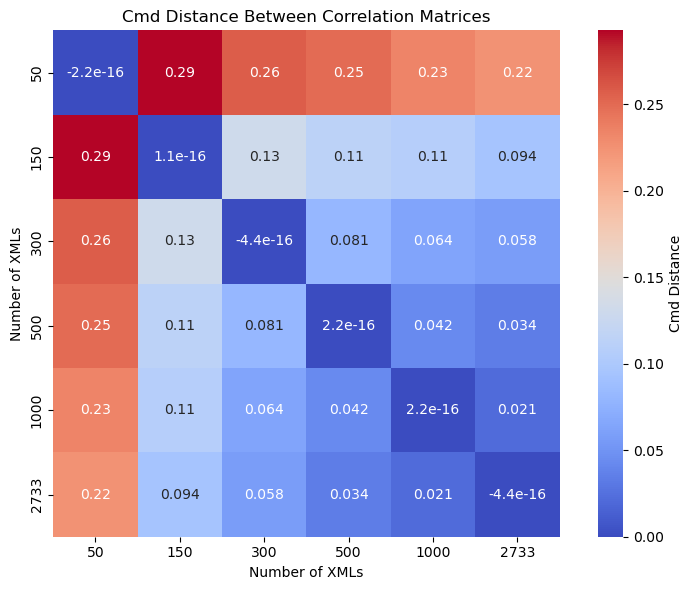

'\nCMD metric:\n    - Normalized: 0 if matrices are identical, 1 if they are orthogonal\n'

In [112]:
plot_correlation_distance_heatmap(corr_dict=dict_old_f_corr, corr_xmls=keys_old, method='cmd')
"""
CMD metric:
    - Normalized: 0 if matrices are identical, 1 if they are orthogonal
"""

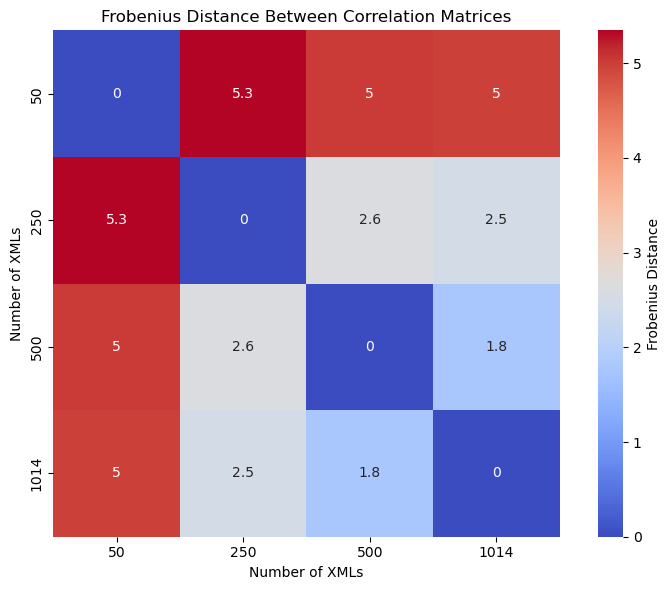

In [113]:
plot_correlation_distance_heatmap(corr_dict=dict_new_f_corr, corr_xmls=keys_new)

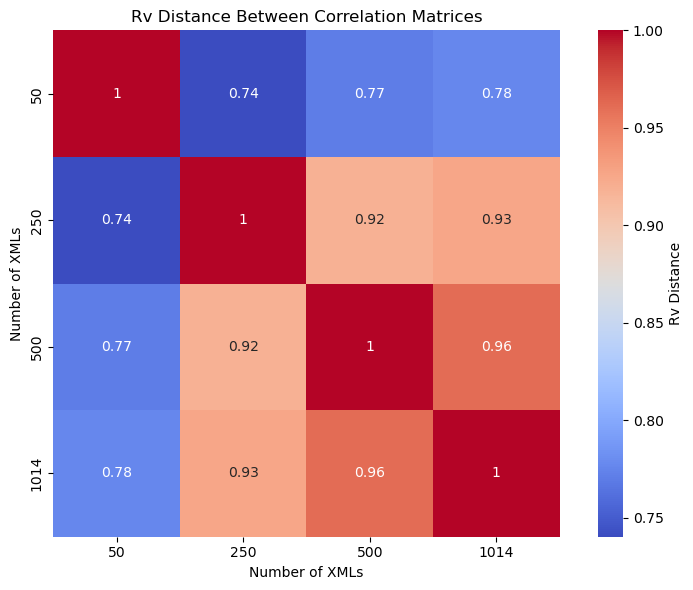

'\nRV metric:\n    - Bounded between 0 and 1\n    - 1 indicates identical structure (up to scale)\n'

In [114]:
plot_correlation_distance_heatmap(corr_dict=dict_new_f_corr, corr_xmls=keys_new, method='rv')
"""
RV metric:
    - Bounded between 0 and 1
    - 1 indicates identical structure (up to scale)
"""

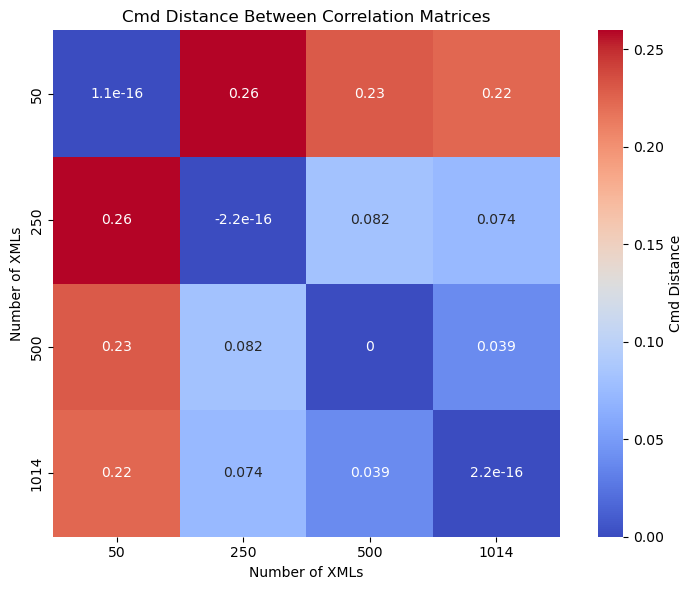

'\nCMD metric:\n    - Normalized: 0 if matrices are identical, 1 if they are orthogonal\n'

In [115]:
plot_correlation_distance_heatmap(corr_dict=dict_new_f_corr, corr_xmls=keys_new, method='cmd')
"""
CMD metric:
    - Normalized: 0 if matrices are identical, 1 if they are orthogonal
"""